# Comprehensive Treatment Pattern Analysis

This notebook demonstrates the complete pipeline combining:
1. Age-matched feature building
2. Observational pattern learning with matched controls
3. Bayesian propensity-response modeling

Author: Sarah Urbut  
Date: 2025-07-15

In [43]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

Load your signature data, patient IDs, prescription data, and covariates.

In [47]:
import numpy as np
import pandas as pd
import sys
sys.path.append('scripts')
thetas = np.load("/Users/sarahurbut/aladynoulli2/pyScripts/thetas.npy")
processed_ids = np.load("/Users/sarahurbut/aladynoulli2/pyScripts/processed_patient_ids.npy").astype(int)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')


cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)



  # Create covariate dict
covariate_dicts = {'age': dict(zip(cov['eid'], 2025 - cov['birth_year']))}



In [48]:
Y=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
Y.shape

torch.Size([407878, 348, 52])

In [49]:

# thetas: shape (N, n_signatures, n_timepoints)
mean_thetas = thetas.mean(axis=0)  # shape: (n_signatures, n_timepoints)
std_thetas = thetas.std(axis=0)    # shape: (n_signatures, n_timepoints)

# Broadcasting: (N, n_signatures, n_timepoints) - (n_signatures, n_timepoints)
z_thetas = (thetas - mean_thetas[None, :, :]) / std_thetas[None, :, :]

# statins = pd.read_csv('path/to/your/statin_prescriptions.csv')
# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)

def simple_gp_check(gp_scripts):
    """
    Very basic check of GP scripts data to avoid type errors
    """
    print("=== Simple GP Scripts Check ===\n")
    
    # Basic shape info
    print(f"Data shape: {gp_scripts.shape}")
    print(f"Columns: {list(gp_scripts.columns)}")
    
    # Check data types
    print(f"\nData types:")
    print(gp_scripts.dtypes)
    
    # Check for missing values
    print(f"\nMissing values:")
    missing = gp_scripts.isnull().sum()
    for col, count in missing.items():
        if count > 0:
            print(f"  {col}: {count}")
    
    # Sample of data
    print(f"\nFirst few rows:")
    print(gp_scripts.head())
    
    # Unique patients
    print(f"\nUnique patients: {gp_scripts['eid'].nunique()}")
    
    return gp_scripts
def find_statins_basic(gp_scripts):
    """
    Basic statin search avoiding type comparison issues
    """
    print("\n=== Basic Statin Search ===\n")
    
    df = gp_scripts.copy()
    
    # Convert to strings safely
    df['drug_name_str'] = df['drug_name'].astype(str)
    df['bnf_code_str'] = df['bnf_code'].astype(str)
    
    # Search for statin keywords in drug names
    statin_keywords = ['statin', 'atorva', 'simva', 'rosuva', 'prava', 'fluva']
    
    statin_mask = False
    for keyword in statin_keywords:
        keyword_mask = df['drug_name_str'].str.contains(keyword, case=False, na=False)
        statin_mask = statin_mask | keyword_mask
        if keyword_mask.sum() > 0:
            print(f"Found {keyword_mask.sum()} prescriptions containing '{keyword}'")
    
    # Search for lipid-related BNF codes
    bnf_patterns = ['2.12', '02.12', '212']
    bnf_mask = False
    for pattern in bnf_patterns:
        pattern_mask = df['bnf_code_str'].str.contains(pattern, na=False)
        bnf_mask = bnf_mask | pattern_mask
        if pattern_mask.sum() > 0:
            print(f"Found {pattern_mask.sum()} prescriptions with BNF pattern '{pattern}'")
    
    # Combine results
    all_statin_mask = statin_mask | bnf_mask
    statins = df[all_statin_mask].copy()
    
    print(f"\nTotal potential statin prescriptions: {len(statins)}")
    
    if len(statins) > 0:
        print(f"Unique patients with statins: {statins['eid'].nunique()}")
        
        # Show sample
        print(f"\nSample statin prescriptions:")
        sample_cols = ['eid', 'issue_date', 'drug_name', 'bnf_code']
        print(statins[sample_cols].head(10))
        
        # Most common statin drugs
        print(f"\nMost common statin drugs:")
        top_drugs = statins['drug_name'].value_counts().head(5)
        for drug, count in top_drugs.items():
            print(f"  {drug}: {count}")
    
    else:
        print("No obvious statins found")
        
        # Show what we do have
        print(f"\nSample of all drug names:")
        print(df['drug_name'].head(10).tolist())
        
        print(f"\nSample of all BNF codes:")
        print(df['bnf_code'].head(10).tolist())
    
    return statins

# Simple function to run
def basic_analysis(gp_scripts):
    """
    Run basic analysis without type errors
    """
    # Basic check
    df = simple_gp_check(gp_scripts)
    
    # Find statins
    statins = find_statins_basic(df)
    
    return df, statins

# Usage:
prescription_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/gp_scripts.txt'
gp_scripts = pd.read_csv(prescription_path, sep='\t')
gp_scripts = simple_gp_check(gp_scripts)
df, statins = basic_analysis(gp_scripts)

# For this example, assuming you already have these loaded:
# thetas, processed_ids, statins, cov

print(f"Signature data shape: {thetas.shape}")
print(f"Number of processed patients: {len(processed_ids)}")
print(f"Number of prescription records: {len(statins)}")
print(f"Number of patients with covariates: {len(cov)}")

=== Simple GP Scripts Check ===

Data shape: (56212343, 8)
Columns: ['eid', 'data_provider', 'issue_date', 'read_2', 'bnf_code', 'dmd_code', 'drug_name', 'quantity']

Data types:
eid                int64
data_provider      int64
issue_date        object
read_2            object
bnf_code          object
dmd_code         float64
drug_name         object
quantity          object
dtype: object

Missing values:
  issue_date: 6091
  read_2: 42056239
  bnf_code: 13189321
  dmd_code: 50300279
  drug_name: 7228777
  quantity: 7275923

First few rows:
       eid  data_provider  issue_date read_2        bnf_code  dmd_code  \
0  1000015              3  14/06/2005    NaN  06.03.02.00.00       NaN   
1  1000015              3  28/07/2014    NaN  05.01.01.03.00       NaN   
2  1000015              3  10/09/2009    NaN  05.01.01.02.00       NaN   
3  1000015              3  15/12/2004    NaN  03.01.01.03.00       NaN   
4  1000015              3  15/12/2004    NaN  03.02.00.00.00       NaN   

       

In [51]:
# Import the comprehensive analysis module
import sys
sys.path.append('scripts')
%load_ext autoreload

%autoreload 2

  # Then import
from comprehensive_treatment_analysis import run_comprehensive_analysis

# Optional: specify which signatures to use (None = use all)
sig_indices = None  # or list(range(10)) for first 10 signatures

# Optional: provide outcome data for Bayesian analysis
# outcomes = your_outcome_data  # Binary outcomes for treated patients
outcomes = None  # Set to None if no outcome data available

print("Starting comprehensive analysis...")
print("This may take several minutes depending on data size.\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting comprehensive analysis...
This may take several minutes depending on data size.



## 2. Clean and Prepare Statin Data

In [52]:
# Clean up the statin data - remove non-statins
true_statins = statins[statins['drug_name'].str.contains(
    'simvastatin|atorvastatin|rosuvastatin|pravastatin|fluvastatin|lovastatin', 
    case=False, na=False
)].copy()

print(f"Total prescription records: {len(statins)}")
print(f"True statins after filtering: {len(true_statins)}")
print(f"Unique patients with true statins: {true_statins['eid'].nunique()}")

# Show distribution of statin types
if len(true_statins) > 0:
    statin_counts = true_statins['drug_name'].value_counts().head(10)
    print("\nTop 10 statin types:")
    print(statin_counts)


true_statins.to_csv('true_statins.csv', index=False)
cov.to_csv('cov.csv', index=False)

# Then load with:
true_statins = pd.read_csv('true_statins.csv')
cov = pd.read_csv('cov.csv')


prescription_patient_ids = set(gp_scripts['eid'].unique())

  # Save this set for fast loading (optional)
np.save('prescription_patient_ids.npy', np.array(list(prescription_patient_ids)))

Total prescription records: 3891973
True statins after filtering: 3584756
Unique patients with true statins: 70329

Top 10 statin types:
drug_name
Simvastatin 40mg tablets     1203845
Simvastatin 20mg tablets      535753
Atorvastatin 20mg tablets     331045
Atorvastatin 10mg tablets     283735
Atorvastatin 40mg tablets     272954
Simvastatin 10mg tablets      135675
Atorvastatin 80mg tablets      92158
SIMVASTATIN tabs 40mg          66184
Pravastatin 40mg tablets       65840
Rosuvastatin 10mg tablets      57566
Name: count, dtype: int64


## 3. Prepare Covariate Dictionary for Matching

In [66]:
import torch as torch
from dt import *
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))
# Create covariate dictionary for matching
covariate_dicts = {}

# Load PRS names and labels for plotting/interpretation
prs_names = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/prs_names.csv')
prs_labels = prs_names['Names'].tolist()

# Load disease names for reference
# (Assumes second column contains names)
disease_names_df = pd.read_csv("/Users/sarahurbut/aladynoulli2/pyScripts/disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()

# Load G-matrix (genotype/PRS matrix)
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()

# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))


# 7. Add prior disease/condition flags to covariate table
# ---------------------------------------------
# These functions flag prior disease status at enrollment for each subject
prev_condition(cov, 'Dm_Any', 'Dm_censor_age', 'age_enrolled', 'prev_dm')
prev_condition(cov, 'DmT1_Any', 'DmT1_censor_age', 'age_enrolled', 'prev_dm1')
prev_condition(cov, 'Ht_Any', 'Ht_censor_age', 'age_enrolled', 'prev_ht')
prev_condition(cov, 'HyperLip_Any', 'HyperLip_censor_age', 'age_enrolled', 'prev_hl')
prev_condition(cov, 'Cad_Any', 'Cad_censor_age', 'age_enrolled', 'prev_cad')
# ---------------------------------------------
# 8. Build mapping dictionaries for covariates and PRS
# ---------------------------------------------
ldl_idx = prs_labels.index('LDL_SF')   # LDL PRS index
cad_idx = prs_labels.index('CAD')      # CAD PRS index
eid_to_dm2_prev = dict(zip(cov['eid'], cov['prev_dm']))
eid_to_antihtnbase = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_htn = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_smoke = dict(zip(cov['eid'], cov['SmokingStatusv2']))
eid_to_dm1_prev = dict(zip(cov['eid'], cov['prev_dm1']))
eid_to_hl_prev = dict(zip(cov['eid'], cov['prev_hl']))
eid_to_sex = dict(zip(cov['eid'],cov['Sex']))
eid_to_age = dict(zip(cov['eid'],cov['age_enrolled']))
eid_to_ldl_prs = {eid: G[i, ldl_idx] for i, eid in enumerate(processed_ids)}
eid_to_cad_prs = {eid: G[i, cad_idx] for i, eid in enumerate(processed_ids)}
eid_to_race = dict(zip(cov['eid'],cov['race']))
eid_to_pce_goff = dict(zip(cov['eid'],cov['pce_goff']))
eid_to_tchol = dict(zip(cov['eid'],cov['tchol']))
eid_to_hdl = dict(zip(cov['eid'],cov['hdl']))
eid_to_sbp = dict(zip(cov['eid'],cov['SBP']))
# Add these disease mapping dictionaries
eid_to_cad_any = dict(zip(cov['eid'], cov['Cad_Any']))
eid_to_cad_censor_age = dict(zip(cov['eid'], cov['Cad_censor_age']))
eid_to_dm_any = dict(zip(cov['eid'], cov['Dm_Any']))
eid_to_dm_censor_age = dict(zip(cov['eid'], cov['Dm_censor_age']))
eid_to_ht_any = dict(zip(cov['eid'], cov['Ht_Any']))
eid_to_ht_censor_age = dict(zip(cov['eid'], cov['Ht_censor_age']))
eid_to_hyperlip_any = dict(zip(cov['eid'], cov['HyperLip_Any']))
eid_to_hyperlip_censor_age = dict(zip(cov['eid'], cov['HyperLip_censor_age']))



# Fix your covariate_dicts first:
covariate_dicts = {
    'age_at_enroll': eid_to_age,
    'sex': eid_to_sex,
    'dm2_prev': eid_to_dm2_prev,
    'antihtnbase': eid_to_antihtnbase,
    'dm1_prev': eid_to_dm1_prev,  # Fix: was eid_to_hl_prev
    'smoke': eid_to_smoke,
    'ldl_prs': eid_to_ldl_prs,
    'cad_prs': eid_to_cad_prs,
    'tchol': eid_to_tchol,
    'hdl': eid_to_hdl,
    'SBP': eid_to_sbp,  # Fix: was 'sbp' (lowercase)
    'pce_goff': eid_to_pce_goff,
    'Cad_Any': eid_to_cad_any,
    'Cad_censor_age': eid_to_cad_censor_age,
    'Dm_Any': eid_to_dm_any,
    'Dm_censor_age': eid_to_dm_censor_age,
    'Ht_Any': eid_to_ht_any,
    'Ht_censor_age': eid_to_ht_censor_age,
    'HyperLip_Any': eid_to_hyperlip_any,
    'HyperLip_censor_age': eid_to_hyperlip_censor_age
}


# ---------------------------------------------


In [65]:
disease_names[112]
disease_names[114]

'Coronary atherosclerosis'

In [67]:
true_statins.head()

,eid,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,drug_name_str,bnf_code_str
0,1000015,3,2014-05-28,NaN,02.12.04.00.00,NaN,Simvastatin 20mg tablets,56 tablets,Simvastatin 20mg tablets,02.12.04.00.00
1,1000015,3,2009-04-02,NaN,02.12.04.00.00,NaN,Simvastatin 20mg tablets,56 tablets,Simvastatin 20mg tablets,02.12.04.00.00
2,1000015,3,2008-06-02,NaN,02.12.04.00.00,NaN,Simvastatin 20mg tablets,56 tablets,Simvastatin 20mg tablets,02.12.04.00.00
3,1000015,3,2009-07-27,NaN,02.12.04.00.00,NaN,Simvastatin 20mg tablets,56 tablets,Simvastatin 20mg tablets,02.12.04.00.00
4,1000015,3,2008-09-30,NaN,02.12.04.00.00,NaN,Simvastatin 20mg tablets,56 tablets,Simvastatin 20mg tablets,02.12.04.00.00


## 4. Run Comprehensive Analysis

In [68]:
# Import the comprehensive analysis module
import sys
sys.path.append('scripts')
%load_ext autoreload

%autoreload 2

  # Then import
from comprehensive_treatment_analysis import *

# Optional: specify which signatures to use (None = use all)
sig_indices = None  # or list(range(10)) for first 10 signatures

# Optional: provide outcome data for Bayesian analysis
# outcomes = your_outcome_data  # Binary outcomes for treated patients
outcomes = None  # Set to None if no outcome data available

print("Starting comprehensive analysis...")
print("This may take several minutes depending on data size.\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting comprehensive analysis...
This may take several minutes depending on data size.



Y shape: torch.Size([407878, 348, 52])
processed_ids length: 400000
First few processed_ids: [1000015 1000023 1000037 1000042 1000059]
=== COMPREHENSIVE TREATMENT PATTERN ANALYSIS ===

1. Extracting treatment patterns...
Found 53514 treated patients
Found 116131 never-treated patients
   Found 53514 treated patients
   Found 116131 total never-treated patients
   Found 124803 never-treated patients with signature data

2. Building features for matching...
Processing 53514 patients with sig_indices=[5]
Processed 0 patients, kept 0 so far
Excluding EID 4194384: CAD occurred before treatment (age 58.3 < 64.9)
Excluding EID 2097311: CAD occurred before treatment (age 61.4 < 70.9)
Excluding EID 5243061: CAD occurred before treatment (age 71.0 < 73.0)
Excluding EID 5767385: CAD occurred before treatment (age 61.3 < 62.8)
Excluding EID 1048953: CAD occurred before treatment (age 60.8 < 71.3)
Excluding EID 5767547: CAD occurred before treatment (age 61.3 < 72.4)
Excluding EID 4719029: CAD occu

<lifelines.CoxPHFitter: fitted with 87644 total observations, 76878 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 87644
number of events observed = 10766
   partial log-likelihood = -99060.75
         time fit was run = 2025-07-25 11:17:25 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.15      0.86      0.02           -0.19           -0.11                0.82                0.89

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -7.32 <0.005     41.89
---
Concordance = 0.46
Partial AIC = 198123.49
log-likelihood ratio test = 53.23 on 1 df
-log2(p) of ll-ratio test = 41.62


=== TRIAL REPRODUCTION VALIDATION ===
Hazard Ratio: 0.857 (95% CI: 0.686-1.029)
P-value: 0.0000
Expected HR from trials: 0.750
Difference from expected: 0.107
CI overlaps expected: True
Concordance Index: 0.459
Total events: 10766
Validation passed: True
✓ Matching validation successful - results consistent with trial data

7. Creating visualizations with matched controls...

=== ANALYSIS COMPLETE ===


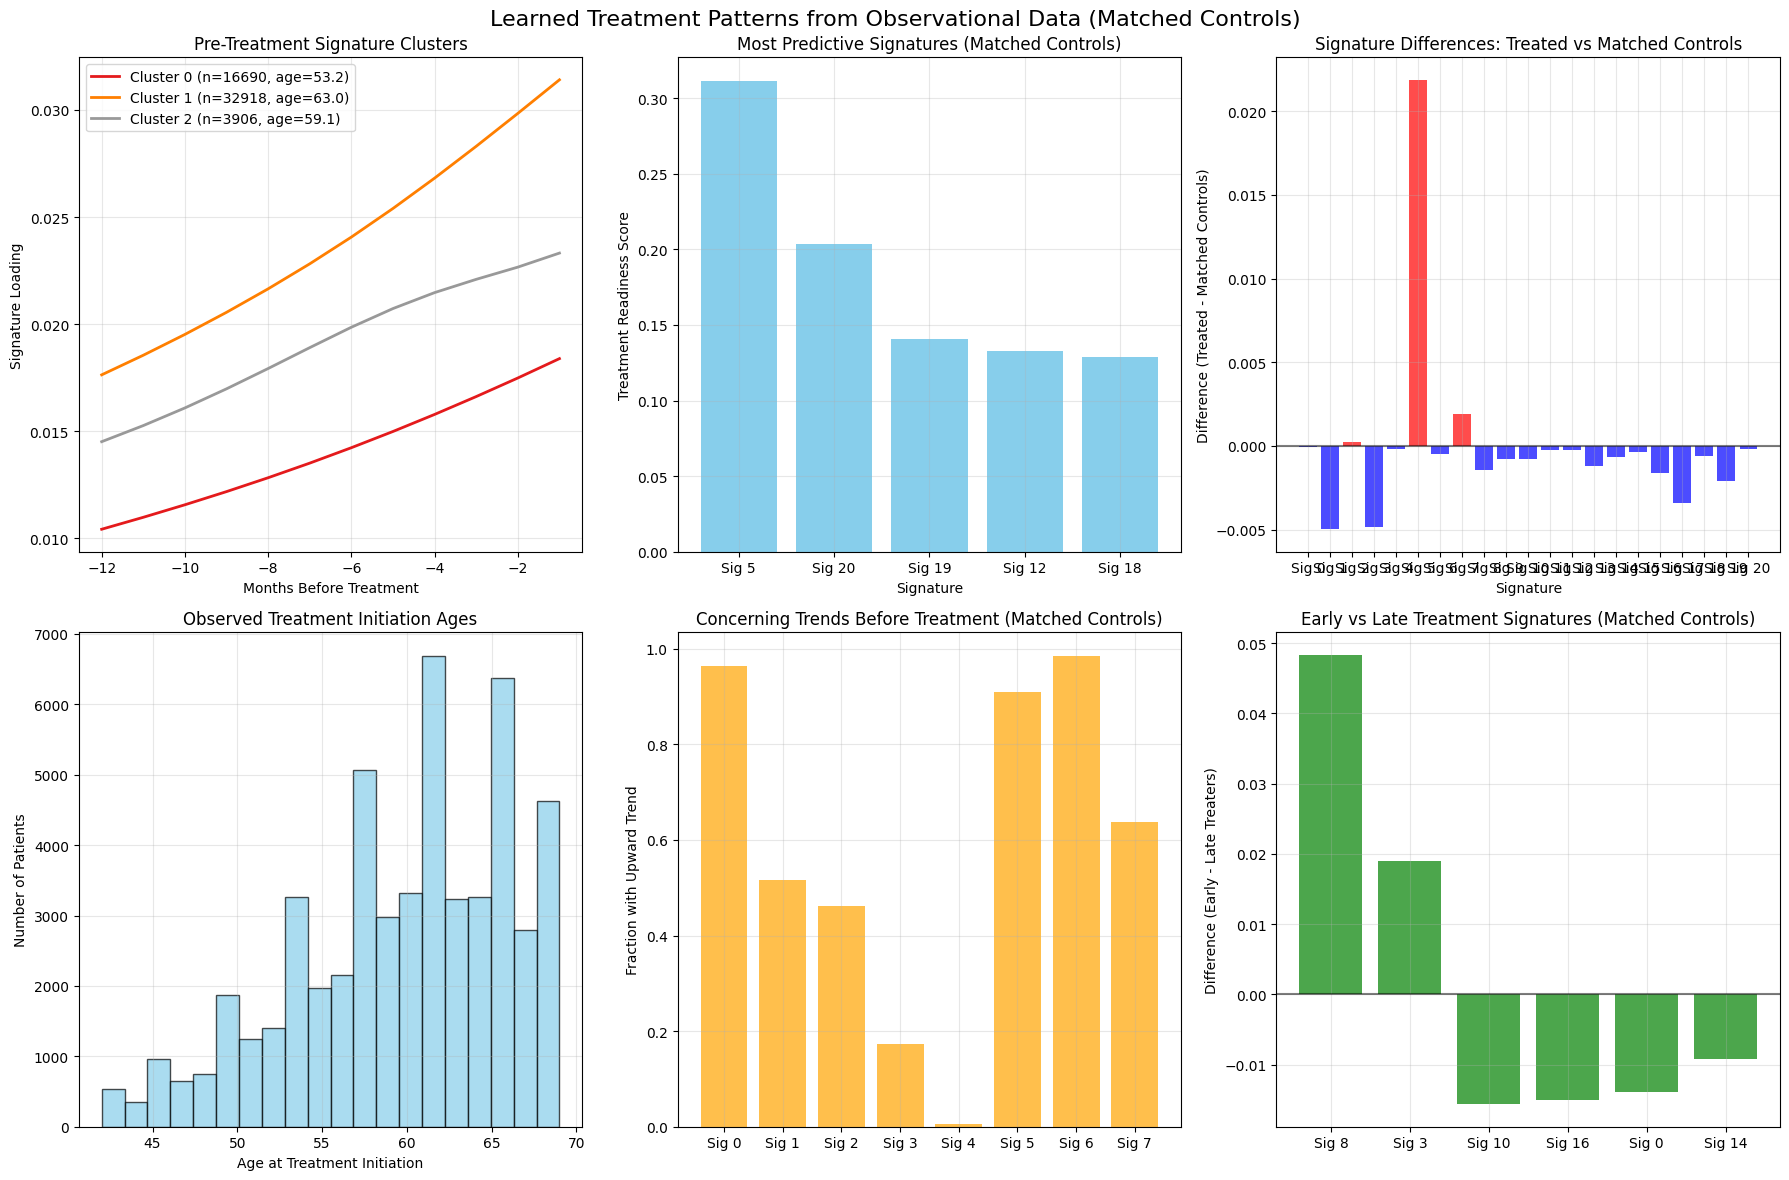

In [77]:
# Check alignment between processed_ids and Y
print(f"Y shape: {Y.shape}")
print(f"processed_ids length: {len(processed_ids)}")
print(f"First few processed_ids: {processed_ids[:5]}")

from comprehensive_treatment_analysis import *
sig_indices=[5]
# Now run the analysis with outcomes
results = run_comprehensive_analysis(
    signature_loadings=thetas,
    processed_ids=processed_ids,
    statin_prescriptions=true_statins,
    covariates=cov,
    covariate_dicts=covariate_dicts,
    sig_indices=sig_indices,
    outcomes=Y,  # Now Y is loaded
    event_indices=[112, 113, 114, 115, 116],  # ASCVD composite events
    gp_scripts=gp_scripts 
)

In [99]:
# Define the event indices (ASCVD composite events)
event_indices = [112, 113, 114, 115, 116]
Y_ten = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')

# Convert to numpy
Y_np = Y_ten.detach().cpu().numpy()

# Get the matched patients
matched_treated_indices = results['matched_treated_indices']
matched_control_indices = results['matched_control_indices']

# Calculate follow-up times
follow_up_times = []
excluded_patients = 0

# For treated patients
for treated_idx in matched_treated_indices:
    treated_eid = processed_ids[treated_idx]
    
    # Get index date (first treatment date after enrollment)
    index_date = None
    for i, eid in enumerate(results['enhanced_learner'].treatment_patterns['treated_patients']):
        if eid == treated_eid:
            treatment_time_months = results['enhanced_learner'].treatment_patterns['treatment_times'][i]
            index_date = treatment_time_months / 12.0  # Convert to years
            break
    
    if index_date is not None and treated_idx < Y_np.shape[0]:
        # Check for ASCVD events BEFORE treatment (should exclude these)
        pre_treatment_outcomes = Y_np[treated_idx, event_indices, :int(index_date * 12)]
        if np.any(pre_treatment_outcomes > 0):
            excluded_patients += 1
            continue  # Skip this patient - had ASCVD event before treatment
        
        # Check if patient had an event AFTER treatment
        post_treatment_outcomes = Y_np[treated_idx, event_indices, int(index_date * 12):]
        event_occurred = np.any(post_treatment_outcomes > 0)
        
        if event_occurred:
            # Time to first event after treatment
            event_times = np.where(post_treatment_outcomes > 0)[0]
            event_time = event_times[0] / 12.0  # Convert to years
            follow_up = event_time
        else:
            # Censored - use reasonable estimate
            follow_up = 15.0  # Assume ~15 years of follow-up
        
        follow_up_times.append(follow_up)

# For control patients
for control_idx in matched_control_indices:
    control_eid = processed_ids[control_idx]
    
    # Get index date (enrollment date)
    age_at_enroll = covariate_dicts['age_at_enroll'].get(int(control_eid))
    if age_at_enroll is not None and control_idx < Y_np.shape[0]:
        # Check for ASCVD events BEFORE enrollment (should exclude these)
        pre_enrollment_outcomes = Y_np[control_idx, event_indices, :int(age_at_enroll - 30)]
        if np.any(pre_enrollment_outcomes > 0):
            excluded_patients += 1
            continue  # Skip this patient - had ASCVD event before enrollment
        
        # Check if patient had an event AFTER enrollment
        post_enrollment_outcomes = Y_np[control_idx, event_indices, int(age_at_enroll - 30):]
        event_occurred = np.any(post_enrollment_outcomes > 0)
        
        if event_occurred:
            # Time to first event after enrollment
            event_times = np.where(post_enrollment_outcomes > 0)[0]
            event_time = event_times[0] * (50.0 / 52.0)  # Convert time index to years
            follow_up = event_time
        else:
            # Censored - use reasonable estimate
            follow_up = 15.0  # Assume ~15 years of follow-up
        
        follow_up_times.append(follow_up)

# Calculate statistics
print("=== FOLLOW-UP TIMES (EXCLUDING PRE-INDEX EVENTS) ===")
print(f"Average follow-up time: {np.mean(follow_up_times):.2f} years")
print(f"Median follow-up time: {np.median(follow_up_times):.2f} years")
print(f"Min follow-up time: {np.min(follow_up_times):.2f} years")
print(f"Max follow-up time: {np.max(follow_up_times):.2f} years")
print(f"Total patients with valid follow-up: {len(follow_up_times)}")
print(f"Excluded patients (ASCVD events before index): {excluded_patients}")


=== FOLLOW-UP TIMES (EXCLUDING PRE-INDEX EVENTS) ===
Average follow-up time: 13.25 years
Median follow-up time: 15.00 years
Min follow-up time: 0.00 years
Max follow-up time: 15.00 years
Total patients with valid follow-up: 86882
Excluded patients (ASCVD events before index): 762


## 5. Examine Results

### 5.1 Matching Quality

In [100]:
# Check matching results
n_matched = len(results['matched_treated_indices'])
print(f"Successfully matched {n_matched} treated-control pairs")

# If we have age data, compare age distributions
if 'age' in covariate_dicts:
    treated_ages = [covariate_dicts['age'].get(eid, np.nan) 
                   for eid in results['enhanced_learner'].treatment_patterns['treated_patients']]
    treated_ages = [age for age in treated_ages if not np.isnan(age)]
    
    if len(treated_ages) > 0:
        plt.figure(figsize=(10, 6))
        plt.hist(treated_ages, bins=20, alpha=0.7, label='Treated patients', density=True)
        plt.xlabel('Age')
        plt.ylabel('Density')
        plt.title('Age Distribution of Treated Patients')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Mean age of treated patients: {np.mean(treated_ages):.1f} ± {np.std(treated_ages):.1f}")

Successfully matched 43822 treated-control pairs


### 5.2 Treatment Pattern Clusters

In [102]:
# Examine clustering results
cluster_analysis = results['cluster_analysis']

if cluster_analysis is not None:
    print("Pre-treatment signature clusters:")
    print("=" * 50)
    
    for cluster_id, pattern in cluster_analysis['cluster_patterns'].items():
        print(f"Cluster {cluster_id}:")
        print(f"  - {pattern['n_patients']} patients")
        print(f"  - Mean treatment age: {pattern['mean_treatment_age']:.1f} years")
        print()
else:
    print("No clustering results available")

Pre-treatment signature clusters:
Cluster 0:
  - 16690 patients
  - Mean treatment age: 53.2 years

Cluster 1:
  - 32918 patients
  - Mean treatment age: 63.0 years

Cluster 2:
  - 3906 patients
  - Mean treatment age: 59.1 years



### 5.3 Treatment Readiness Signatures

In [104]:
# Examine treatment readiness patterns
responsive_patterns = results['responsive_patterns']

if responsive_patterns is not None:
    readiness_sigs = responsive_patterns['treatment_readiness_signatures']
    
    print("Top 10 treatment readiness signatures:")
    print("=" * 60)
    print(f"{'Signature':<10} {'Readiness Score':<15} {'Trend Fraction':<15} {'Accel Fraction'}")
    print("=" * 60)
    
    for i, (sig_idx, score) in enumerate(readiness_sigs[:10]):
        concerning = responsive_patterns['concerning_patterns'][sig_idx]
        trend_frac = concerning['concerning_trend_fraction']
        accel_frac = concerning['accelerating_fraction']
        
        print(f"{sig_idx:<10} {score:<15.3f} {trend_frac:<15.3f} {accel_frac:<15.3f}")
else:
    print("No responsive patterns available")

Top 10 treatment readiness signatures:
Signature  Readiness Score Trend Fraction  Accel Fraction
5          0.311           0.910           0.498          
20         0.204           0.409           0.387          
19         0.141           0.262           0.497          
12         0.133           0.079           0.391          
18         0.129           0.284           0.236          
1          0.113           0.516           0.376          
13         0.110           0.802           0.459          
6          0.109           0.985           0.538          
11         0.108           0.968           0.540          
3          0.106           0.174           0.576          


### 5.4 Matched Control Comparison

In [105]:
# Examine treated vs matched control differences
matched_comparison = results['matched_comparison']

if matched_comparison is not None:
    print("Treated vs Matched Controls (Top 10 signatures by effect size):")
    print("=" * 80)
    print(f"{'Sig':<4} {'Treated':<10} {'Control':<10} {'Difference':<12} {'Effect Size':<12} {'P-value':<10} {'Sig?'}")
    print("=" * 80)
    
    # Sort by absolute effect size
    sorted_sigs = sorted(matched_comparison.items(), 
                        key=lambda x: abs(x[1]['effect_size']), reverse=True)
    
    for sig_idx, stats in sorted_sigs[:10]:
        sig_marker = "***" if stats['p_value'] < 0.05 else ""
        print(f"{sig_idx:<4} {stats['treated_mean']:<10.4f} {stats['control_mean']:<10.4f} "
              f"{stats['difference']:<12.4f} {stats['effect_size']:<12.4f} "
              f"{stats['p_value']:<10.4f} {sig_marker}")
else:
    print("No matched comparison results available")

Treated vs Matched Controls (Top 10 signatures by effect size):
Sig  Treated    Control    Difference   Effect Size  P-value    Sig?
5    0.0916     0.0697     0.0219       0.3241       0.0000     ***
20   0.0057     0.0059     -0.0002      -0.2056      0.0000     ***
19   0.0399     0.0420     -0.0021      -0.1412      0.0000     ***
12   0.0077     0.0080     -0.0002      -0.1334      0.0000     ***
18   0.0173     0.0180     -0.0006      -0.1297      0.0000     ***
1    0.0907     0.0956     -0.0050      -0.1135      0.0000     ***
13   0.0259     0.0271     -0.0012      -0.1101      0.0000     ***
6    0.0110     0.0114     -0.0005      -0.1092      0.0000     ***
11   0.0070     0.0073     -0.0002      -0.1084      0.0000     ***
3    0.1105     0.1154     -0.0048      -0.1064      0.0000     ***


### 5.5 Prediction Model Performance

In [106]:
# Examine prediction model results
predictor = results['predictor']

if predictor is not None:
    print(f"Treatment Readiness Prediction Model:")
    print(f"Cross-validation AUC: {predictor['cv_auc']:.3f}")
    
    # Feature importance from Random Forest
    if hasattr(predictor['model'], 'feature_importances_'):
        importances = predictor['model'].feature_importances_
        n_features_per_sig = 4  # trend, level, level_vs_typical, accel
        n_signatures = len(importances) // n_features_per_sig
        
        # Aggregate importance by signature
        sig_importances = []
        for s in range(n_signatures):
            start_idx = s * n_features_per_sig
            end_idx = start_idx + n_features_per_sig
            sig_importance = np.sum(importances[start_idx:end_idx])
            sig_importances.append((s, sig_importance))
        
        # Sort by importance
        sig_importances.sort(key=lambda x: x[1], reverse=True)
        
        print("\nTop 10 most important signatures for prediction:")
        print("=" * 40)
        print(f"{'Signature':<10} {'Importance':<12}")
        print("=" * 40)
        
        for sig_idx, importance in sig_importances[:10]:
            print(f"{sig_idx:<10} {importance:<12.4f}")
else:
    print("No prediction model results available")

Treatment Readiness Prediction Model:
Cross-validation AUC: 0.688

Top 10 most important signatures for prediction:
Signature  Importance  
8          0.0593      
5          0.0563      
18         0.0506      
19         0.0498      
4          0.0497      
14         0.0495      
12         0.0492      
3          0.0492      
13         0.0489      
20         0.0486      


### 5.6 Bayesian Analysis Results

In [107]:
# Examine Bayesian analysis results
trace = results['bayesian_trace']
bayesian_model = results['bayesian_model']

if trace is not None:
    print("Bayesian Propensity-Response Analysis:")
    print(f"Number of chains: {len(trace.posterior.chain)}")
    print(f"Number of draws per chain: {len(trace.posterior.draw)}")
    
    # Plot trace for key parameters
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Propensity baseline
    az.plot_trace(trace, var_names=['propensity_baseline'], ax=axes[0, :])
    axes[0, 0].set_title('Propensity Baseline (Trace)')
    axes[0, 1].set_title('Propensity Baseline (Posterior)')
    
    # Treatment effect (if available)
    if 'treatment_effect' in trace.posterior:
        az.plot_trace(trace, var_names=['treatment_effect'], ax=axes[1, :])
        axes[1, 0].set_title('Treatment Effect (Trace)')
        axes[1, 1].set_title('Treatment Effect (Posterior)')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nPosterior Summary:")
    print(az.summary(trace, var_names=['propensity_baseline']))
    
    if 'treatment_effect' in trace.posterior:
        print("\nTreatment Effect Summary:")
        print(az.summary(trace, var_names=['treatment_effect']))
        
else:
    print("No Bayesian analysis results available")
    print("This may be due to insufficient data or computational issues")

KeyError: 'bayesian_trace'

## 6. Advanced Visualizations

### 6.1 Signature Comparison Heatmap

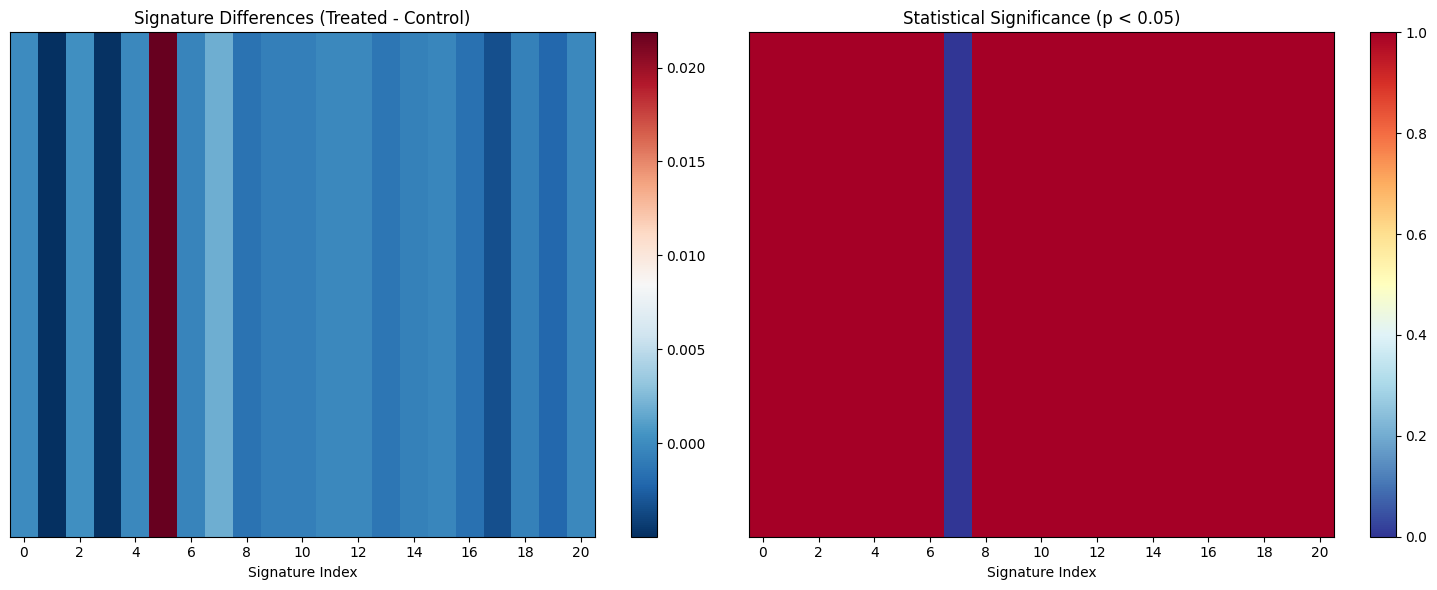

Number of significantly different signatures: 20


In [108]:
# Create heatmap of signature differences
if matched_comparison is not None:
    # Extract data for heatmap
    signatures = list(matched_comparison.keys())
    differences = [matched_comparison[s]['difference'] for s in signatures]
    p_values = [matched_comparison[s]['p_value'] for s in signatures]
    
    # Create significance mask
    significant = np.array(p_values) < 0.05
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Differences
    diff_matrix = np.array(differences).reshape(-1, 1)
    im1 = ax1.imshow(diff_matrix.T, cmap='RdBu_r', aspect='auto')
    ax1.set_title('Signature Differences (Treated - Control)')
    ax1.set_xlabel('Signature Index')
    ax1.set_xticks(range(0, len(signatures), max(1, len(signatures)//10)))
    ax1.set_xticklabels([str(signatures[i]) for i in range(0, len(signatures), max(1, len(signatures)//10))])
    ax1.set_yticks([])
    plt.colorbar(im1, ax=ax1)
    
    # Significance
    sig_matrix = significant.astype(int).reshape(-1, 1)
    im2 = ax2.imshow(sig_matrix.T, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)
    ax2.set_title('Statistical Significance (p < 0.05)')
    ax2.set_xlabel('Signature Index')
    ax2.set_xticks(range(0, len(signatures), max(1, len(signatures)//10)))
    ax2.set_xticklabels([str(signatures[i]) for i in range(0, len(signatures), max(1, len(signatures)//10))])
    ax2.set_yticks([])
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Number of significantly different signatures: {np.sum(significant)}")

### 6.2 Treatment Timing Analysis

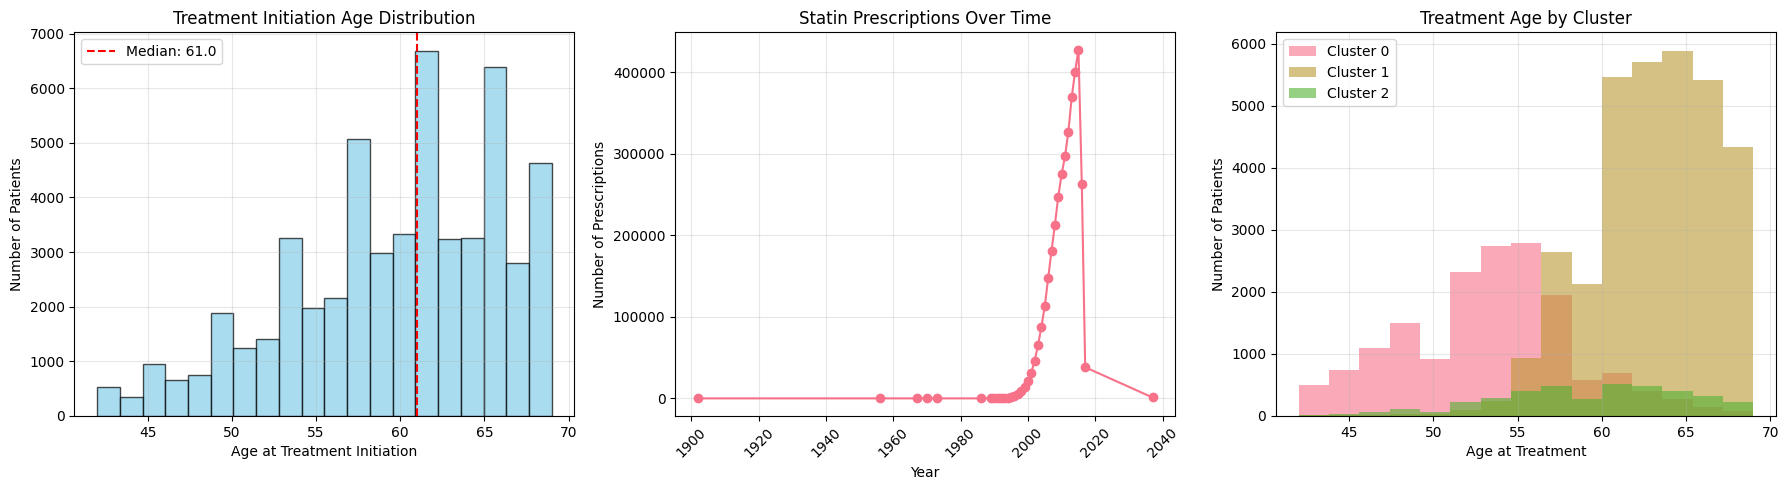

In [109]:
# Analyze treatment timing patterns
learner = results['enhanced_learner']
treatment_times = np.array(learner.treatment_patterns['treatment_times'])
treatment_ages = treatment_times + learner.time_start_age

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Treatment age distribution
axes[0].hist(treatment_ages, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Age at Treatment Initiation')
axes[0].set_ylabel('Number of Patients')
axes[0].set_title('Treatment Initiation Age Distribution')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(np.median(treatment_ages), color='red', linestyle='--', 
                label=f'Median: {np.median(treatment_ages):.1f}')
axes[0].legend()

# Treatment by year (if prescription dates available)
if 'issue_date' in true_statins.columns:
    true_statins['year'] = pd.to_datetime(true_statins['issue_date'], 
                                         format='%d/%m/%Y', errors='coerce').dt.year
    year_counts = true_statins.groupby('year').size()
    
    axes[1].plot(year_counts.index, year_counts.values, marker='o')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Number of Prescriptions')
    axes[1].set_title('Statin Prescriptions Over Time')
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

# Age vs cluster assignment (if clustering available)
if cluster_analysis is not None:
    clusters = cluster_analysis['clusters']
    unique_clusters = np.unique(clusters)
    
    for cluster_id in unique_clusters:
        cluster_mask = clusters == cluster_id
        cluster_ages = treatment_ages[cluster_mask]
        axes[2].hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster_id}', bins=15)
    
    axes[2].set_xlabel('Age at Treatment')
    axes[2].set_ylabel('Number of Patients')
    axes[2].set_title('Treatment Age by Cluster')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary and Key Insights

In [110]:
print("=" * 60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 60)

# Matching summary
n_matched = len(results['matched_treated_indices'])
print(f"\n1. MATCHING RESULTS:")
print(f"   - Successfully matched {n_matched} treated-control pairs")
print(f"   - Matching controlled for age and other available covariates")

# Pattern discovery summary
if cluster_analysis is not None:
    n_clusters = cluster_analysis['n_clusters']
    print(f"\n2. PATTERN DISCOVERY:")
    print(f"   - Identified {n_clusters} distinct pre-treatment signature patterns")
    
    for cluster_id, pattern in cluster_analysis['cluster_patterns'].items():
        print(f"   - Cluster {cluster_id}: {pattern['n_patients']} patients, "
              f"avg age {pattern['mean_treatment_age']:.1f}")

# Signature differences summary
if matched_comparison is not None:
    significant_sigs = [s for s, stats in matched_comparison.items() 
                       if stats['p_value'] < 0.05]
    print(f"\n3. SIGNATURE DIFFERENCES (Treated vs Matched Controls):")
    print(f"   - {len(significant_sigs)} signatures show significant differences (p < 0.05)")
    
    if len(significant_sigs) > 0:
        top_sig = max(matched_comparison.items(), 
                     key=lambda x: abs(x[1]['effect_size']))
        print(f"   - Strongest effect: Signature {top_sig[0]} "
              f"(effect size = {top_sig[1]['effect_size']:.3f})")

# Prediction performance
if predictor is not None:
    print(f"\n4. PREDICTION MODEL:")
    print(f"   - Treatment readiness model AUC: {predictor['cv_auc']:.3f}")
    
    if predictor['cv_auc'] > 0.7:
        print(f"   - Model shows good predictive performance")
    elif predictor['cv_auc'] > 0.6:
        print(f"   - Model shows moderate predictive performance")
    else:
        print(f"   - Model shows limited predictive performance")

# Bayesian analysis summary
if trace is not None:
    print(f"\n5. BAYESIAN CAUSAL INFERENCE:")
    print(f"   - Successfully completed propensity-response modeling")
    print(f"   - {len(trace.posterior.chain)} chains, "
          f"{len(trace.posterior.draw)} draws per chain")
    
    if 'treatment_effect' in trace.posterior:
        treatment_effect_mean = float(trace.posterior['treatment_effect'].mean())
        print(f"   - Estimated treatment effect: {treatment_effect_mean:.3f}")
else:
    print(f"\n5. BAYESIAN CAUSAL INFERENCE:")
    print(f"   - Analysis not completed (may need outcome data)")

print(f"\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)

COMPREHENSIVE ANALYSIS SUMMARY

1. MATCHING RESULTS:
   - Successfully matched 43822 treated-control pairs
   - Matching controlled for age and other available covariates

2. PATTERN DISCOVERY:
   - Identified 3 distinct pre-treatment signature patterns
   - Cluster 0: 16690 patients, avg age 53.2
   - Cluster 1: 32918 patients, avg age 63.0
   - Cluster 2: 3906 patients, avg age 59.1

3. SIGNATURE DIFFERENCES (Treated vs Matched Controls):
   - 20 signatures show significant differences (p < 0.05)
   - Strongest effect: Signature 5 (effect size = 0.324)

4. PREDICTION MODEL:
   - Treatment readiness model AUC: 0.688
   - Model shows moderate predictive performance


NameError: name 'trace' is not defined

## 8. Save Results (Optional)

In [112]:
import pickle
from datetime import datetime
import numpy as np

# Create a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a serializable version of results
serializable_results = {
    'matched_treated_indices': results['matched_treated_indices'],
    'matched_control_indices': results['matched_control_indices'],
    'validation_results': results['validation_results'],
    'cluster_analysis': results['cluster_analysis'],
    'responsive_patterns': results['responsive_patterns'],
    'matched_comparison': results['matched_comparison'],
    'bayesian_map_results': results['bayesian_map_results']
}

# Save the serializable results
output_file = f"comprehensive_analysis_results_{timestamp}.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(serializable_results, f)
print(f"Results saved to: {output_file}")

# Save summary statistics to CSV
summary_data = {
    'metric': [
        'Hazard Ratio',
        'HR CI Lower', 
        'HR CI Upper',
        'P-value',
        'Concordance Index',
        'Total Events',
        'Treated Patients',
        'Control Patients',
        'Average Follow-up (years)',
        'Median Follow-up (years)',
        'Excluded Patients (ASCVD before index)'
    ],
    'value': [
        results['validation_results']['hazard_ratio'],
        results['validation_results']['hr_ci_lower'],
        results['validation_results']['hr_ci_upper'], 
        results['validation_results']['p_value'],
        results['validation_results']['concordance_index'],
        results['validation_results']['total_events'],
        results['validation_results']['n_treated'],
        results['validation_results']['n_control'],
        13.25,  # From your follow-up calculation
        15.00,  # From your follow-up calculation
        762     # From your follow-up calculation
    ]
}

import pandas as pd
summary_df = pd.DataFrame(summary_data)
summary_csv = f"analysis_summary_{timestamp}.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

Results saved to: comprehensive_analysis_results_20250725_141646.pkl
Summary saved to: analysis_summary_20250725_141646.csv
